In [1]:
import json
from pathlib import Path

annotation_data_path = Path("/local/scratch/carlyn.1/datasets/ap-10k/annotations/ap10k-test-split1.json")

with open(annotation_data_path, 'r') as f:
    ann_data = json.load(f)

ann_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [15]:
print(ann_data['categories'][1])

{'id': 2, 'name': 'argali sheep', 'supercategory': 'Bovidae', 'keypoints': ['left_eye', 'right_eye', 'nose', 'neck', 'root_of_tail', 'left_shoulder', 'left_elbow', 'left_front_paw', 'right_shoulder', 'right_elbow', 'right_front_paw', 'left_hip', 'left_knee', 'left_back_paw', 'right_hip', 'right_knee', 'right_back_paw'], 'skeleton': [[1, 2], [1, 3], [2, 3], [3, 4], [4, 5], [4, 6], [6, 7], [7, 8], [4, 9], [9, 10], [10, 11], [5, 12], [12, 13], [13, 14], [5, 15], [15, 16], [16, 17]]}


In [3]:
for cat_info in ann_data['categories']:
    print(cat_info['id'], cat_info['name'])
    
# 33 giraffe

1 antelope
2 argali sheep
3 bison
4 buffalo
5 cow
6 sheep
7 arctic fox
8 dog
9 fox
10 wolf
11 beaver
12 alouatta
13 monkey
14 noisy night monkey
15 spider monkey
16 uakari
17 deer
18 moose
19 hamster
20 elephant
21 horse
22 zebra
23 bobcat
24 cat
25 cheetah
26 jaguar
27 king cheetah
28 leopard
29 lion
30 panther
31 snow leopard
32 tiger
33 giraffe
34 hippo
35 chimpanzee
36 gorilla
37 orangutan
38 rabbit
39 skunk
40 mouse
41 rat
42 otter
43 weasel
44 raccoon
45 rhino
46 marmot
47 squirrel
48 pig
49 mole
50 black bear
51 brown bear
52 panda
53 polar bear
54 bat


In [4]:
for key, value in ann_data['annotations'][0].items():
    print(key, value)

id 114
image_id 102
category_id 1
bbox [424, 205, 552, 456]
area 251712
iscrowd 0
num_keypoints 10
keypoints [885, 355, 2, 810, 361, 2, 843, 412, 2, 864, 529, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 729, 571, 2, 822, 604, 2, 678, 619, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 590, 473, 2, 456, 622, 2, 549, 631, 2]


In [5]:
import os
# Count number of data files (10015 files)
total = 0
for _, _, files in os.walk(Path("/local/scratch/carlyn.1/datasets/ap-10k/data")):
    total += len(files)

total

10015

In [6]:
ann_point = ann_data['annotations'][0]
img_info = ann_data['images'][0]

assert ann_point['image_id'] == img_info['id'], "IDs must match"



img_path = Path("/local/scratch/carlyn.1/datasets/ap-10k/data") / img_info['file_name']
img_path

PosixPath('/local/scratch/carlyn.1/datasets/ap-10k/data/000000000102.jpg')

In [21]:
# Based on the file here: https://github.com/AlexTheBad/AP-10K/blob/main/tools/dataset/parse_animalpose_dataset.py
# It seems that the format is <x>, <y>, <is_valid>, <x2>, <y2>, <is_valid2>, ...?
# As long as the <is_valid> is not 0, it should be good. Even though the file only puts either 0 or 2

keypoints = []
all_keypoints = []
keypoint_visible = []
for i in range(len(ann_point['keypoints']) // 3):
    si = i*3
    x, y, is_valid = ann_point['keypoints'][si:si+3]
    if is_valid > 0:
        keypoints.append((x, y))
    all_keypoints.append((x, y))
    keypoint_visible.append(is_valid > 0)
keypoints

[(885, 355),
 (810, 361),
 (843, 412),
 (864, 529),
 (729, 571),
 (822, 604),
 (678, 619),
 (590, 473),
 (456, 622),
 (549, 631)]

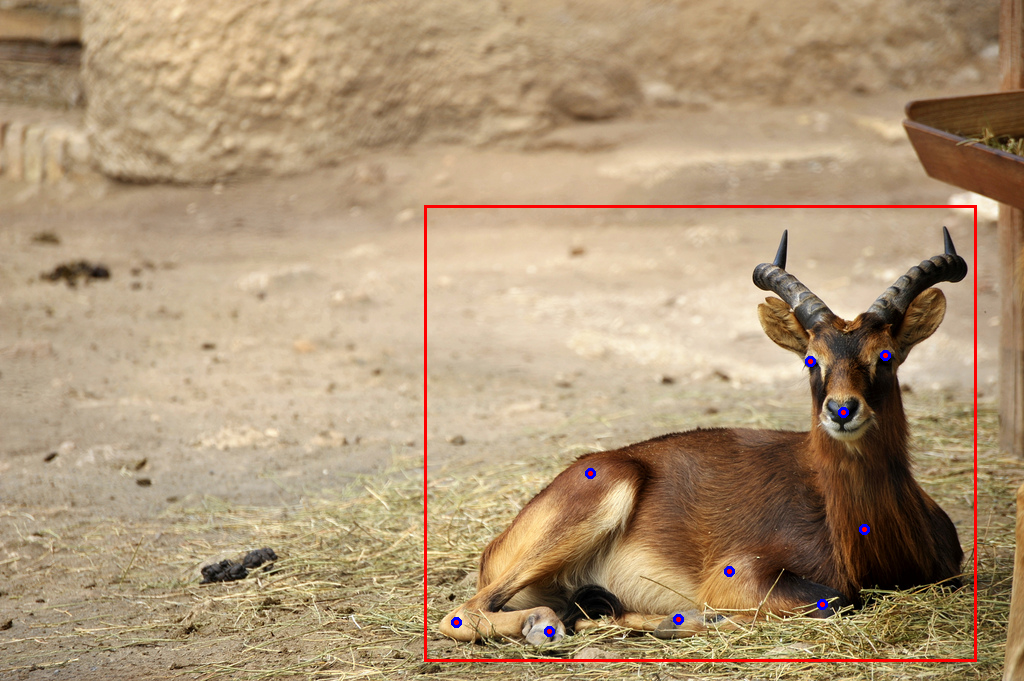

In [8]:
from PIL import Image, ImageDraw

img = Image.open(img_path)

imd = ImageDraw.Draw(img)

r = 5
for x, y in keypoints:
    imd.ellipse((x-r, y-r, x+r, y+r), fill='red', outline='blue', width=3)
    
x, y, w, h = ann_point['bbox']
imd.rectangle((x, y, x+w, y+h), fill=None, outline='red', width=3)

img

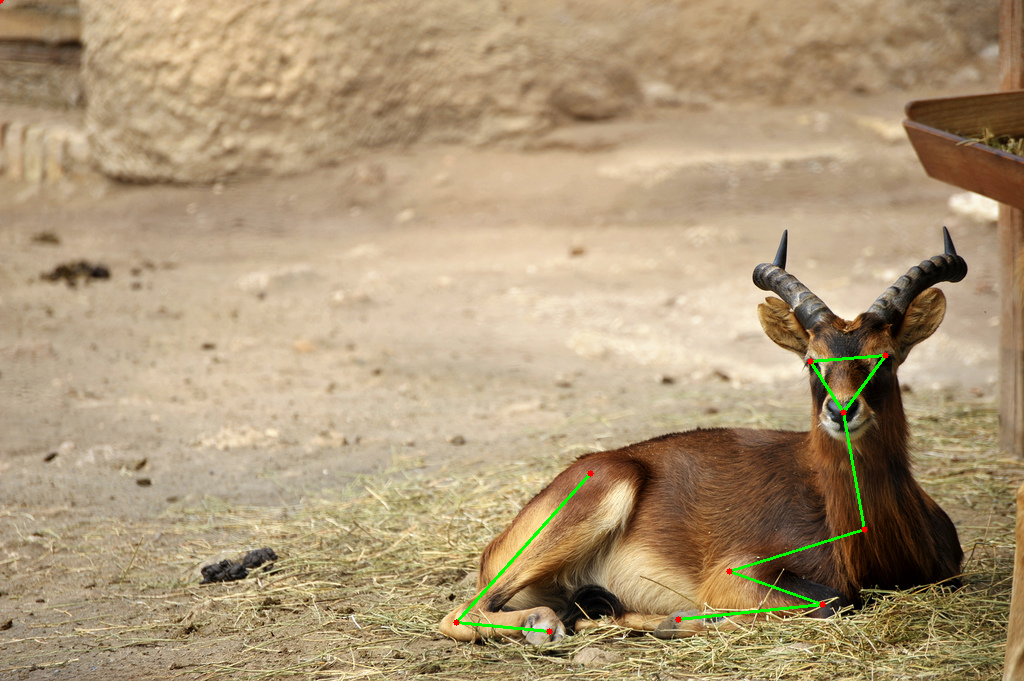

In [24]:
import numpy as np
from mmengine.structures import InstanceData
from mmpose.structures import PoseDataSample
from mmpose.visualization import PoseLocalVisualizer


image=np.array(Image.open(img_path))

# Have to subtract all values by 1, since the skeleton is 1 indexed
skeleton = [[link[0]-1, link[1]-1] for link in ann_data['categories'][1]['skeleton']]

pose_local_visualizer = PoseLocalVisualizer(radius=3, line_width=2, link_color='green')
gt_instances = InstanceData()
gt_instances.keypoints = np.array([all_keypoints])
gt_pose_data_sample = PoseDataSample()
gt_pose_data_sample.gt_instances = gt_instances
dataset_meta = {'skeleton_links': skeleton}
pose_local_visualizer.set_dataset_meta(dataset_meta)
pose_img = pose_local_visualizer.add_datasample('image', image,
                        gt_pose_data_sample, draw_pred=False)
Image.fromarray(pose_img)
